Notebook to generate some healpy maps of the data and associated random catalogues, to see how well the the generation of randoms and also sampling for completeness has worked. Also for a visualisation tool as to what the catalogues look like and how they are distributed. Just change the cat_vars_path variable then run.

In [3]:
%load_ext autoreload
%autoreload

# import modules
from importlib import reload

# import sys
# sys.path.append('../../clustering_pipeline/')
# # from imports import *
# from data_io import *

import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from structures import catalogue_variables
from data_io import load_object, read_to_df
from aux import gen_fast_map
import scipy.interpolate as interpolate

In [5]:
# the catalogue vars for the data sets we want to investigate (Change as applicable then run the rest of the notebook):
cat_vars_path = 'catalogue_vars/2021_05_catalogue_vars'
cat_vars = load_object(cat_vars_path)
cat_vars.__dict__


# for the n(z) plot, specify if in real space ('real'), or redshift space ('redshift', only for BG and LRG)
real_or_redshift = 'real'

In [3]:


# main function for data validation and visualisation
def validate_catalogues(cat_vars, real_or_redshift, hist_bins=100, healpy_n=3):
    
    tracers = cat_vars.tracers
#     tracers = ['LyA'] # for quick testing
    
    for tracer in tracers:
        
        print('Creating plot grid for the %s sample.'%(tracer))
        
        
        # determine if working in real or redshift space, making adjustments that QSO and LyA samples dont have the redshift space option at present
        comov_col = 'comov_dist'
        Z_col = 'REDSHIFT_ESTIMATE'
        if (real_or_redshift == 'redshift') and (tracer in ['BG', 'LRG']):
            comov_col = 'comov_dist_S'
            Z_col = 'redshift_S'

        # load the data random catalogues
        df_in = read_to_df(cat_vars.data_input + 'input_reduced_' + tracer + '.fits')
        df_out = read_to_df(cat_vars.data_output + 'output_reduced_' + tracer + '.fits')
        df_rand_in = read_to_df(cat_vars.randoms_input + 'table_' + tracer + '.fits') # input randoms
        df_rand_out = read_to_df(cat_vars.randoms_output + 'table_' + tracer + '.fits') # output randoms
        
        # comoving dist -> redshift splines
        z_arr_spl = np.linspace(0, max(df_in[Z_col].values)*1.1, 10000)
        comov_arr_spl = [cat_vars.cosmo.comoving_distance(z).value for z in z_arr_spl]
        spl_r_to_z = interpolate.interp1d(comov_arr_spl, z_arr_spl)

        # set up healpy pixels
        # healpy_n of 2 corresponds to a pixel with radius of ~ 0.7 deg and area of ~ 1.5 square deg
        nside = 12 * pow(healpy_n, 2)
        npixels = 12 * pow(nside, 2)

        # get pixel numbers (indices) of the data
        pixel_vals_in = hp.ang2pix(nside, df_in["RA"].values, df_in["DEC"].values, lonlat=True)
        pixel_vals_out = hp.ang2pix(nside, df_out["RA"].values, df_out["DEC"].values, lonlat=True)
        pixel_vals_rand_in = hp.ang2pix(nside, df_rand_in["RA"].values, df_rand_in["DEC"].values, lonlat=True)
        pixel_vals_rand_out = hp.ang2pix(nside, df_rand_out["RA"].values, df_rand_out["DEC"].values, lonlat=True)

        # get a hist of the comoving distance distribution and get the bin volume for plotting n(z)
#         z_bins = np.linspace(min(df_in[Zcol].values), max(df_in[Zcol].values), hist_bins)
#         z_bins_mid = 0.5*(z_bins[1:] + z_bins[:-1])
        comov_bins = np.linspace(min(df_in[comov_col]), max(df_in[comov_col]), hist_bins)
        comov_bins_mid = 0.5*(comov_bins[1:] + comov_bins[:-1])
        z_bins_mid = spl_r_to_z(comov_bins_mid)
        bin_vol = np.zeros_like(comov_bins_mid)
        for i in range(len(bin_vol)):
            bin_vol = cat_vars.fsky*(4/3)*np.pi*(comov_bins[i+1]**3 - comov_bins[i]**3)
        hist_dat_in = np.histogram(df_in[comov_col].values, bins = comov_bins)[0]
        hist_dat_out = np.histogram(df_out[comov_col].values, bins = comov_bins)[0]
        hist_rand_in = np.histogram(df_rand_in['comov_dist'].values, bins = comov_bins)[0]
        hist_rand_out = np.histogram(df_rand_out['comov_dist'].values, bins = comov_bins)[0]

        # create healpy map of the data and randoms - the map is a 1d array where the index = pixel number,
        # and index value = points (i.e. galaxies) inside that pixel
        map_in = gen_fast_map(pixel_vals_in, npixels)
        map_out = gen_fast_map(pixel_vals_out, npixels)
        map_rand_in = gen_fast_map(pixel_vals_rand_in, npixels)
        map_rand_out = gen_fast_map(pixel_vals_rand_out, npixels)
        map_multiplier_in = np.divide(map_rand_in, map_in, out=np.zeros_like(map_rand_in, dtype=np.float64), where=map_in!=0)
        map_multiplier_out = np.divide(map_rand_out, map_out, out=np.zeros_like(map_rand_out, dtype=np.float64), where=map_out!=0)
        map_completeness = 100*np.divide(map_out, map_in, out=np.zeros_like(map_out, dtype=np.float64), where=map_in!=0)

        # get the random multiplier, then divide the random map by this then subtract the map to get residuals
        rand_multi_in = len(df_rand_in) / len(df_in)
        rand_multi_out = len(df_rand_out) / len(df_out)
        map_residuals_in = (map_rand_in / rand_multi_in) - map_in
        map_residuals_out = (map_rand_out / rand_multi_out) - map_out



        fig = plt.figure(figsize=(30, 20))

        # ********************************************************
        plt.subplot(3,3,1)
        hp.mollview(map_in, title="%s Input data map. $N_{g, In}$ = %s"%(tracer, len(df_in)), unit="Gal. density per pixel", hold=True)

        # ********************************************************
        plt.subplot(3,3,2)
        hp.mollview(map_rand_in, title="%s Input random map. $N_{r, In}$ = %s"%(tracer, len(df_rand_in)), unit="Gal. density per pixel", hold=True)

        # ********************************************************
        plt.subplot(3,3,3)
        hp.mollview(map_residuals_in, title="Input %s residuals (randoms/rand_multi - data)"%(tracer), unit="Gal. density per pixel", hold=True)
        
        # ********************************************************
        plt.subplot(3,3,4)
        hp.mollview(map_out, title="%s Output data map. $N_{g, Out}$ = %s"%(tracer, len(df_out)), unit="Gal. density per pixel", hold=True)

        # ********************************************************
        plt.subplot(3,3,5)
        hp.mollview(map_rand_out, title="%s Output random map. $N_{r, Out}$ = %s"%(tracer, len(df_rand_out)), unit="Gal. density per pixel", hold=True)

        # ********************************************************
        plt.subplot(3,3,6)
        hp.mollview(map_residuals_out, title="Output %s residuals (randoms/rand_multi - data)"%(tracer), unit="Gal. density per pixel", hold=True)
        
        # ********************************************************
        plt.subplot(3,3,7)
        hp.mollview(map_completeness, title="%s completeness. Avg completeness = %s %%"%(tracer, np.round(100*(len(df_out)/len(df_in)), 1)), unit="Completeness % per pixel", hold=True)
        
        # ********************************************************
        plt.subplot(3,3,8)
#         plt.title('%s - Histogram of the redshift counts'%(tracer), size=16)
        plt.title('%s - Number density'%(tracer), size=16)
        plt.xlabel('Redshift', size=14)
        plt.ylabel('$n(z)$ [$h^3$ Mpc$^{-3}$]', size=14)
        plt.xticks(size=14)
        plt.yticks(size=14)
        plt.yscale('log')
        plt.plot(z_bins_mid, hist_dat_in/bin_vol, marker='o', c='red', label='Input data')
        plt.plot(z_bins_mid, (hist_rand_in/bin_vol)/cat_vars.rand_multi, marker='x', c='orange', label='Input rands / rand_multi')
        plt.plot(z_bins_mid, hist_dat_out/bin_vol, marker='o', c='blue', label='Output data')
        plt.plot(z_bins_mid, (hist_rand_out/bin_vol)/cat_vars.rand_multi, marker='x', c='skyblue', label='Output rands / rand_multi')
        plt.legend(fontsize=14)
        
        # ********************************************************
        plt.subplot(3,3,9)
        plt.title('%s - Histogram of the randoms multiplier amount per pixel'%(tracer), size=16)
        plt.xlabel('Randoms multiplier', size=14)
        plt.ylabel('Pixel counts', size=14)
        plt.xticks(size=14)
        plt.yticks(size=14)
        
        # for input
        bin_end = int(np.max(map_multiplier_in))
        bins = np.linspace(0, bin_end, bin_end+1)
        hist,bins = np.histogram(map_multiplier_in, bins=bins)
        bins_mid = 0.5*(bins[1:] + bins [:-1])
        plt.bar(np.delete(bins_mid,0), np.delete(hist,0), width=3, lw=2, alpha=0.6, color='red', label='Input')
        
        # for output
        bin_end = int(np.max(map_multiplier_out))
        bins = np.linspace(0, bin_end, bin_end+1)
        hist,bins = np.histogram(map_multiplier_out, bins=bins)
        bins_mid = 0.5*(bins[1:] + bins [:-1])
        plt.bar(np.delete(bins_mid,0), np.delete(hist,0), width=3, lw=2, alpha=0.3, color='blue', label='Output')
        
        plt.axvline(cat_vars.rand_multi, c='black', ls='--', label='Expected multiplier = %s'%(cat_vars.rand_multi))
        plt.legend(fontsize=14)
        
        # ********************************************************

        plt.savefig(cat_vars.plots_validation + 'main_plots_' + tracer + '.pdf', dpi=150, bbox_inches='tight')
        plt.show()
        
        print('\n\n\n')
        print('***********************************************************************************************')
        print('\n\n')

Creating plot grid for the BG sample.


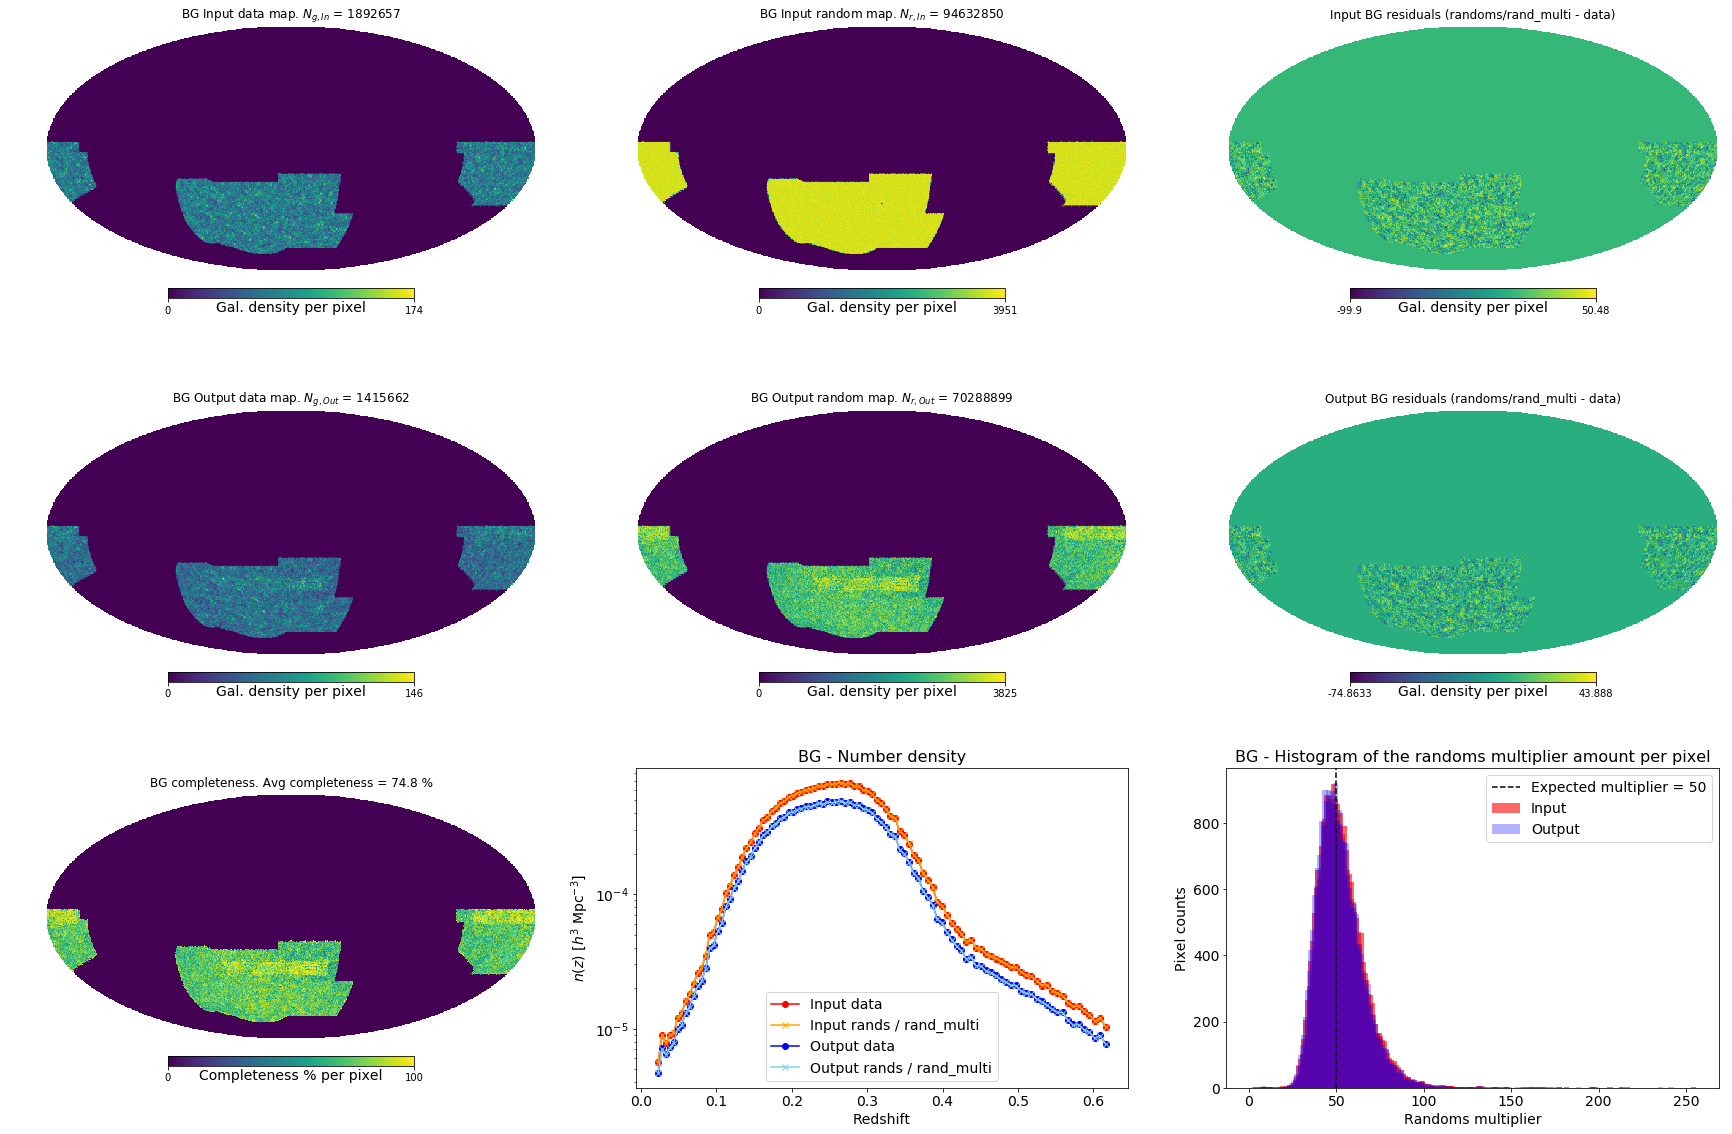





***********************************************************************************************



Creating plot grid for the LRG sample.


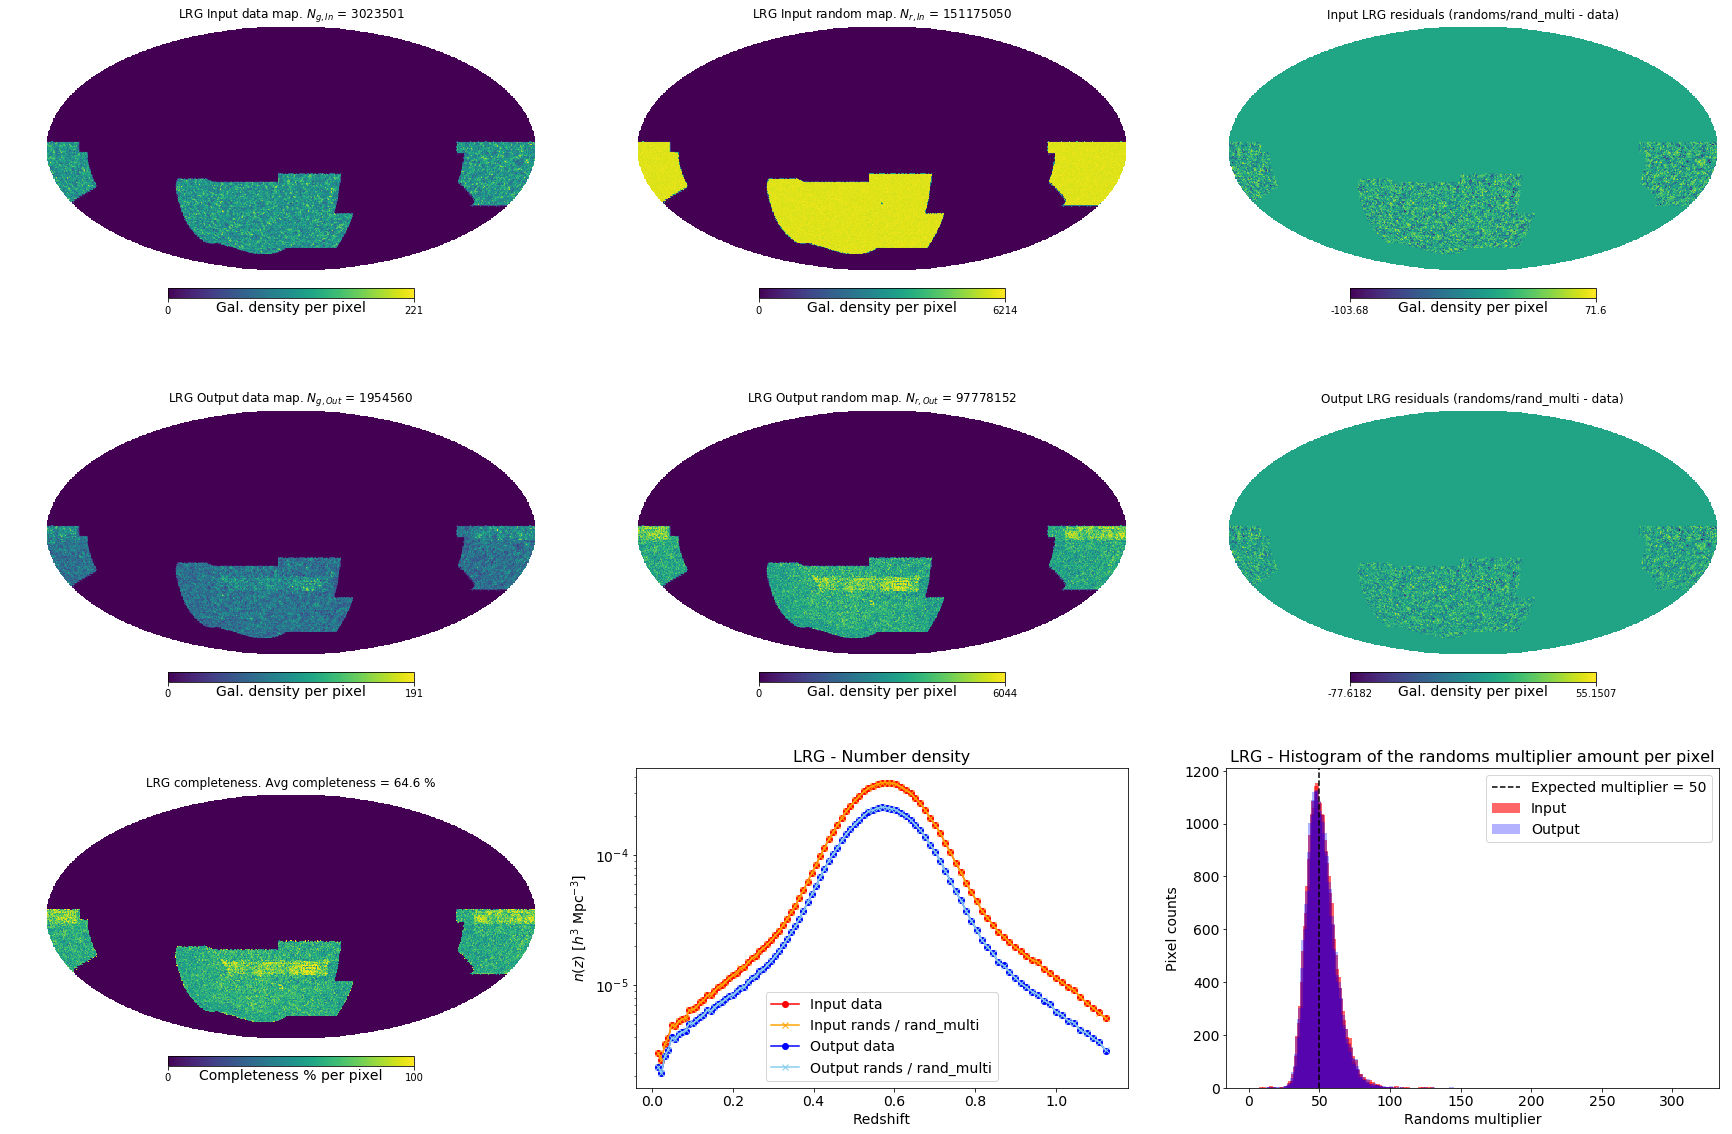





***********************************************************************************************



Creating plot grid for the QSO sample.


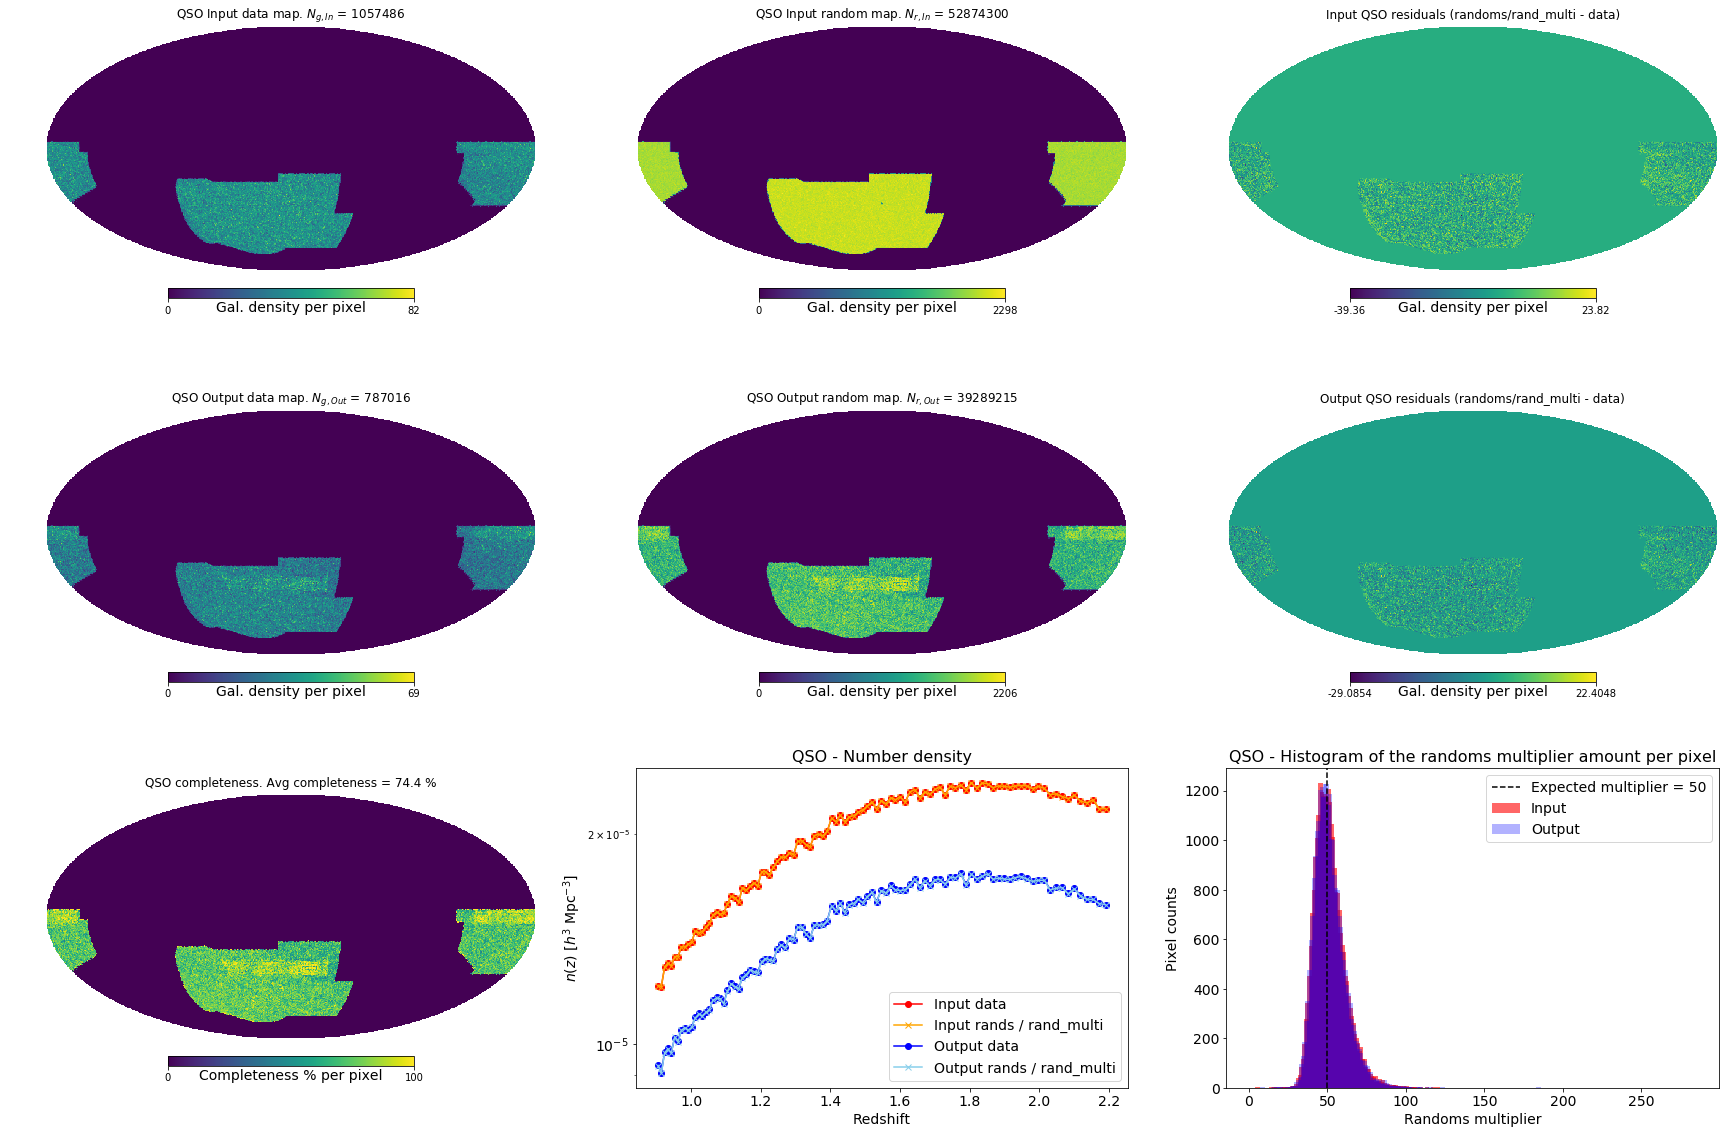





***********************************************************************************************



Creating plot grid for the LyA sample.


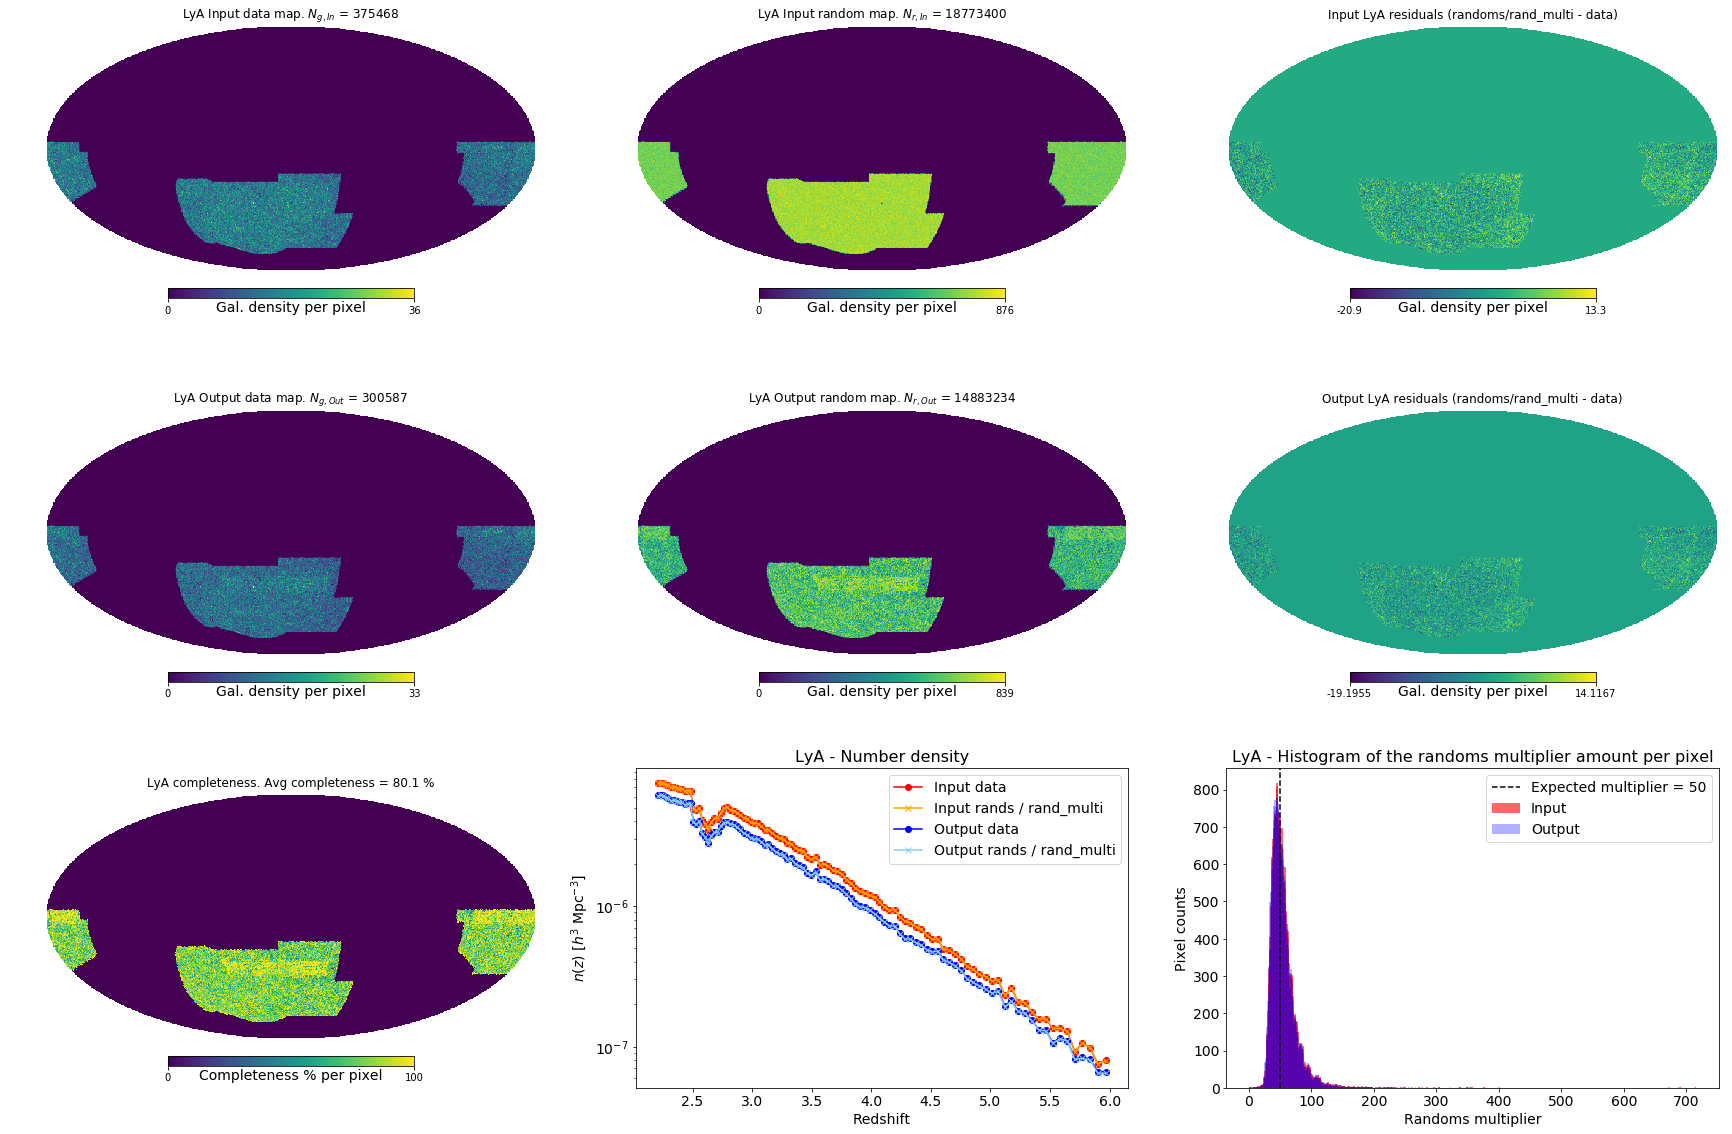





***********************************************************************************************



CPU times: user 3min 17s, sys: 1min 57s, total: 5min 15s
Wall time: 5min 3s


In [4]:
%%time

validate_catalogues(cat_vars, real_or_redshift, hist_bins=100, healpy_n=3)